# This Notebook

This notebook is/was developed as part of an ad-hoc study group formed with strangers from across the internet. 

The goal of the study group is to work through a series of Kaggle competitions as individuals, and then share strategies as group. Since many of these competitions have highly optimal solutions publicly available, we've all agreed that we will not read literature, blogs, forum-posts or code that is directly tied to the competition. 


# The Contest

https://www.kaggle.com/c/ieee-fraud-detection

## Exerpt:

Imagine standing at the check-out counter at the grocery store with a long line behind you and the cashier not-so-quietly announces that your card has been declined. In this moment, you probably aren’t thinking about the data science that determined your fate.

Embarrassed, and certain you have the funds to cover everything needed for an epic nacho party for 50 of your closest friends, you try your card again. Same result. As you step aside and allow the cashier to tend to the next customer, you receive a text message from your bank. “Press 1 if you really tried to spend $500 on cheddar cheese.”

While perhaps cumbersome (and often embarrassing) in the moment, this fraud prevention system is actually saving consumers millions of dollars per year. Researchers from the IEEE Computational Intelligence Society (IEEE-CIS) want to improve this figure, while also improving the customer experience. With higher accuracy fraud detection, you can get on with your chips without the hassle.

IEEE-CIS works across a variety of AI and machine learning areas, including deep neural networks, fuzzy systems, evolutionary computation, and swarm intelligence. Today they’re partnering with the world’s leading payment service company, Vesta Corporation, seeking the best solutions for fraud prevention industry, and now you are invited to join the challenge.

In this competition, you’ll benchmark machine learning models on a challenging large-scale dataset. The data comes from Vesta's real-world e-commerce transactions and contains a wide range of features from device type to product features. You also have the opportunity to create new features to improve your results.

If successful, you’ll improve the efficacy of fraudulent transaction alerts for millions of people around the world, helping hundreds of thousands of businesses reduce their fraud loss and increase their revenue. And of course, you will save party people just like you the hassle of false positives.

***Submissions are evaluated on area under the ROC curve between the predicted probability and the observed target.***




In [411]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import  auc, roc_auc_score, roc_curve, plot_roc_curve


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('.'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

.\ieee-fraud-detection.zip
.\sample_submission.csv
.\test_identity.csv
.\test_transaction.csv
.\train_identity.csv
.\train_transaction.csv
.\transaction_obj_dummies.csv


In [312]:
def guess_if_categorical(arr):
    is_numeric = np.isreal(arr).all()
    
    if is_numeric:
        tests= {"integers":is_integers(arr), 
         "zero_one":has_zero_or_one(arr), 
         "is_linspace_unique":is_linspace_unique(arr),
         "has_limited_entries(arr)":has_limited_entries(arr)}
        if all(tests.values()):
            return True
        else:
            return tests
    else:
        return has_limited_entries(arr)    
    
    
def is_integers(arr):
    nans = np.isnan(arr)
    
    return np.equal(np.mod(arr[~nans], 1), 0).all()

def has_zero_or_one(arr):
    return (1 in arr) or (0 in arr)

def is_linspace_unique(arr):
    nans = np.isnan(arr)

    a, b = np.unique(arr[~nans]),  np.linspace(np.min(arr),np.max( arr), int(np.max(arr)-np.min(arr)+1))
    return np.array_equal(a, b)

def has_limited_entries(arr, limit=50):
    
    nans = np.isnan(arr)
    return len(np.unique(arr[~nans])) <= limit



In [2]:
os.chdir("data")
os.listdir()

['sample_submission.csv',
 'test_identity.csv',
 'test_transaction.csv',
 'train_identity.csv',
 'train_transaction.csv',
 'transaction_obj_dummies.csv']

In [345]:
identity = pd.read_csv("train_identity.csv")
transaction = pd.read_csv("train_transaction.csv")

In [4]:

identity_t = pd.read_csv("test_identity.csv")
transaction_t = pd.read_csv("test_transaction.csv")

In [5]:
identity.head()

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,...,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,...,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


In [6]:
identity.describe(include="all")

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
count,1.442330e+05,144233.000000,140872.000000,66324.000000,66324.000000,136865.000000,136865.000000,5155.000000,5155.000000,74926.000000,...,140282,77586.000000,73289,77805,140985,140985,140985,140985,140810,118666
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,130,NaN,260,4,2,2,2,2,2,1786
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,chrome 63.0,NaN,1920x1080,match_status:2,T,F,T,F,desktop,Windows
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,22000,NaN,16874,60011,77814,134066,110452,73922,85165,47722
mean,3.236329e+06,-10.170502,174716.584708,0.060189,-0.058938,1.615585,-6.698710,13.285354,-38.600388,0.091023,...,NaN,26.508597,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,1.788496e+05,14.347949,159651.816856,0.598231,0.701015,5.249856,16.491104,11.384207,26.084899,0.983842,...,NaN,3.737502,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,2.987004e+06,-100.000000,1.000000,-13.000000,-28.000000,-72.000000,-100.000000,-46.000000,-100.000000,-36.000000,...,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,3.077142e+06,-10.000000,67992.000000,0.000000,0.000000,0.000000,-6.000000,5.000000,-48.000000,0.000000,...,NaN,24.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,3.198818e+06,-5.000000,125800.500000,0.000000,0.000000,0.000000,0.000000,14.000000,-34.000000,0.000000,...,NaN,24.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,3.392923e+06,-5.000000,228749.000000,0.000000,0.000000,1.000000,0.000000,22.000000,-23.000000,0.000000,...,NaN,32.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [386]:
%%time
corr = transaction.iloc[:, 1:].corr()
for i in range(len(corr)):
    corr.iloc[i, i] = 0
(corr.abs().max() > .95).sum()

Wall time: 4min 45s


191

In [404]:
def strong_corr(pd_corr_series):
    ans = pd_corr_series[(pd_corr_series >.95)]
    return ans.index.to_list()

correlating_col_summary = corr[corr.abs().max() > .95].agg(strong_corr, axis=1)

In [406]:
transaction[correlating_col_summary["C1"]].corrwith(transaction.C1)

C2     0.995089
C4     0.967800
C6     0.982238
C8     0.967746
C10    0.958202
C11    0.996515
C14    0.951761
dtype: float64

In [409]:
transaction[correlating_col_summary.index].isna().sum()

C1           0
C2           0
C4           0
C6           0
C7           0
         ...  
V330    508189
V331    508189
V332    508189
V333    508189
V334    508189
Length: 191, dtype: int64

In [410]:
transaction.shape

(590540, 394)

In [9]:
for c in transaction.columns: print(c);

TransactionID
isFraud
TransactionDT
TransactionAmt
ProductCD
card1
card2
card3
card4
card5
card6
addr1
addr2
dist1
dist2
P_emaildomain
R_emaildomain
C1
C2
C3
C4
C5
C6
C7
C8
C9
C10
C11
C12
C13
C14
D1
D2
D3
D4
D5
D6
D7
D8
D9
D10
D11
D12
D13
D14
D15
M1
M2
M3
M4
M5
M6
M7
M8
M9
V1
V2
V3
V4
V5
V6
V7
V8
V9
V10
V11
V12
V13
V14
V15
V16
V17
V18
V19
V20
V21
V22
V23
V24
V25
V26
V27
V28
V29
V30
V31
V32
V33
V34
V35
V36
V37
V38
V39
V40
V41
V42
V43
V44
V45
V46
V47
V48
V49
V50
V51
V52
V53
V54
V55
V56
V57
V58
V59
V60
V61
V62
V63
V64
V65
V66
V67
V68
V69
V70
V71
V72
V73
V74
V75
V76
V77
V78
V79
V80
V81
V82
V83
V84
V85
V86
V87
V88
V89
V90
V91
V92
V93
V94
V95
V96
V97
V98
V99
V100
V101
V102
V103
V104
V105
V106
V107
V108
V109
V110
V111
V112
V113
V114
V115
V116
V117
V118
V119
V120
V121
V122
V123
V124
V125
V126
V127
V128
V129
V130
V131
V132
V133
V134
V135
V136
V137
V138
V139
V140
V141
V142
V143
V144
V145
V146
V147
V148
V149
V150
V151
V152
V153
V154
V155
V156
V157
V158
V159
V160
V161
V162
V163
V164
V165
V166
V167

In [10]:
transaction.TransactionID.duplicated().sum()

0

In [11]:
identity.TransactionID.duplicated().sum()

0

In [12]:
identity

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,...,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,...,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144228,3577521,-15.0,145955.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,chrome 66.0 for android,NaN,NaN,NaN,F,F,T,F,mobile,F3111 Build/33.3.A.1.97
144229,3577526,-5.0,172059.0,NaN,NaN,1.0,-5.0,NaN,NaN,NaN,...,chrome 55.0 for android,32.0,855x480,match_status:2,T,F,T,F,mobile,A574BL Build/NMF26F
144230,3577529,-20.0,632381.0,NaN,NaN,-1.0,-36.0,NaN,NaN,NaN,...,chrome 65.0 for android,NaN,NaN,NaN,F,F,T,F,mobile,Moto E (4) Plus Build/NMA26.42-152
144231,3577531,-5.0,55528.0,0.0,0.0,0.0,-7.0,NaN,NaN,0.0,...,chrome 66.0,24.0,2560x1600,match_status:2,T,F,T,F,desktop,MacOS


In [13]:
transaction.isFraud.mean()

0.03499000914417313

In [14]:
corr_df = pd.DataFrame()


In [15]:
temp = []
for col in transaction.select_dtypes("float64"):
    corr=transaction[["isFraud", col]].corr().iloc[0,1]
    temp.append([col, corr])

In [16]:
pd.DataFrame(temp).sort_values(1, ascending=False).head(10)

,0,1
293,V257,0.383060
282,V246,0.366878
280,V244,0.364129
278,V242,0.360590
237,V201,0.328005
236,V200,0.318783
225,V189,0.308219
224,V188,0.303582
294,V258,0.297151
81,V45,0.281832


In [17]:
t10_corr = transaction[["V257", "V246","V244", "V242","V201", "V200", "V189","V188","V258", "V45"]]

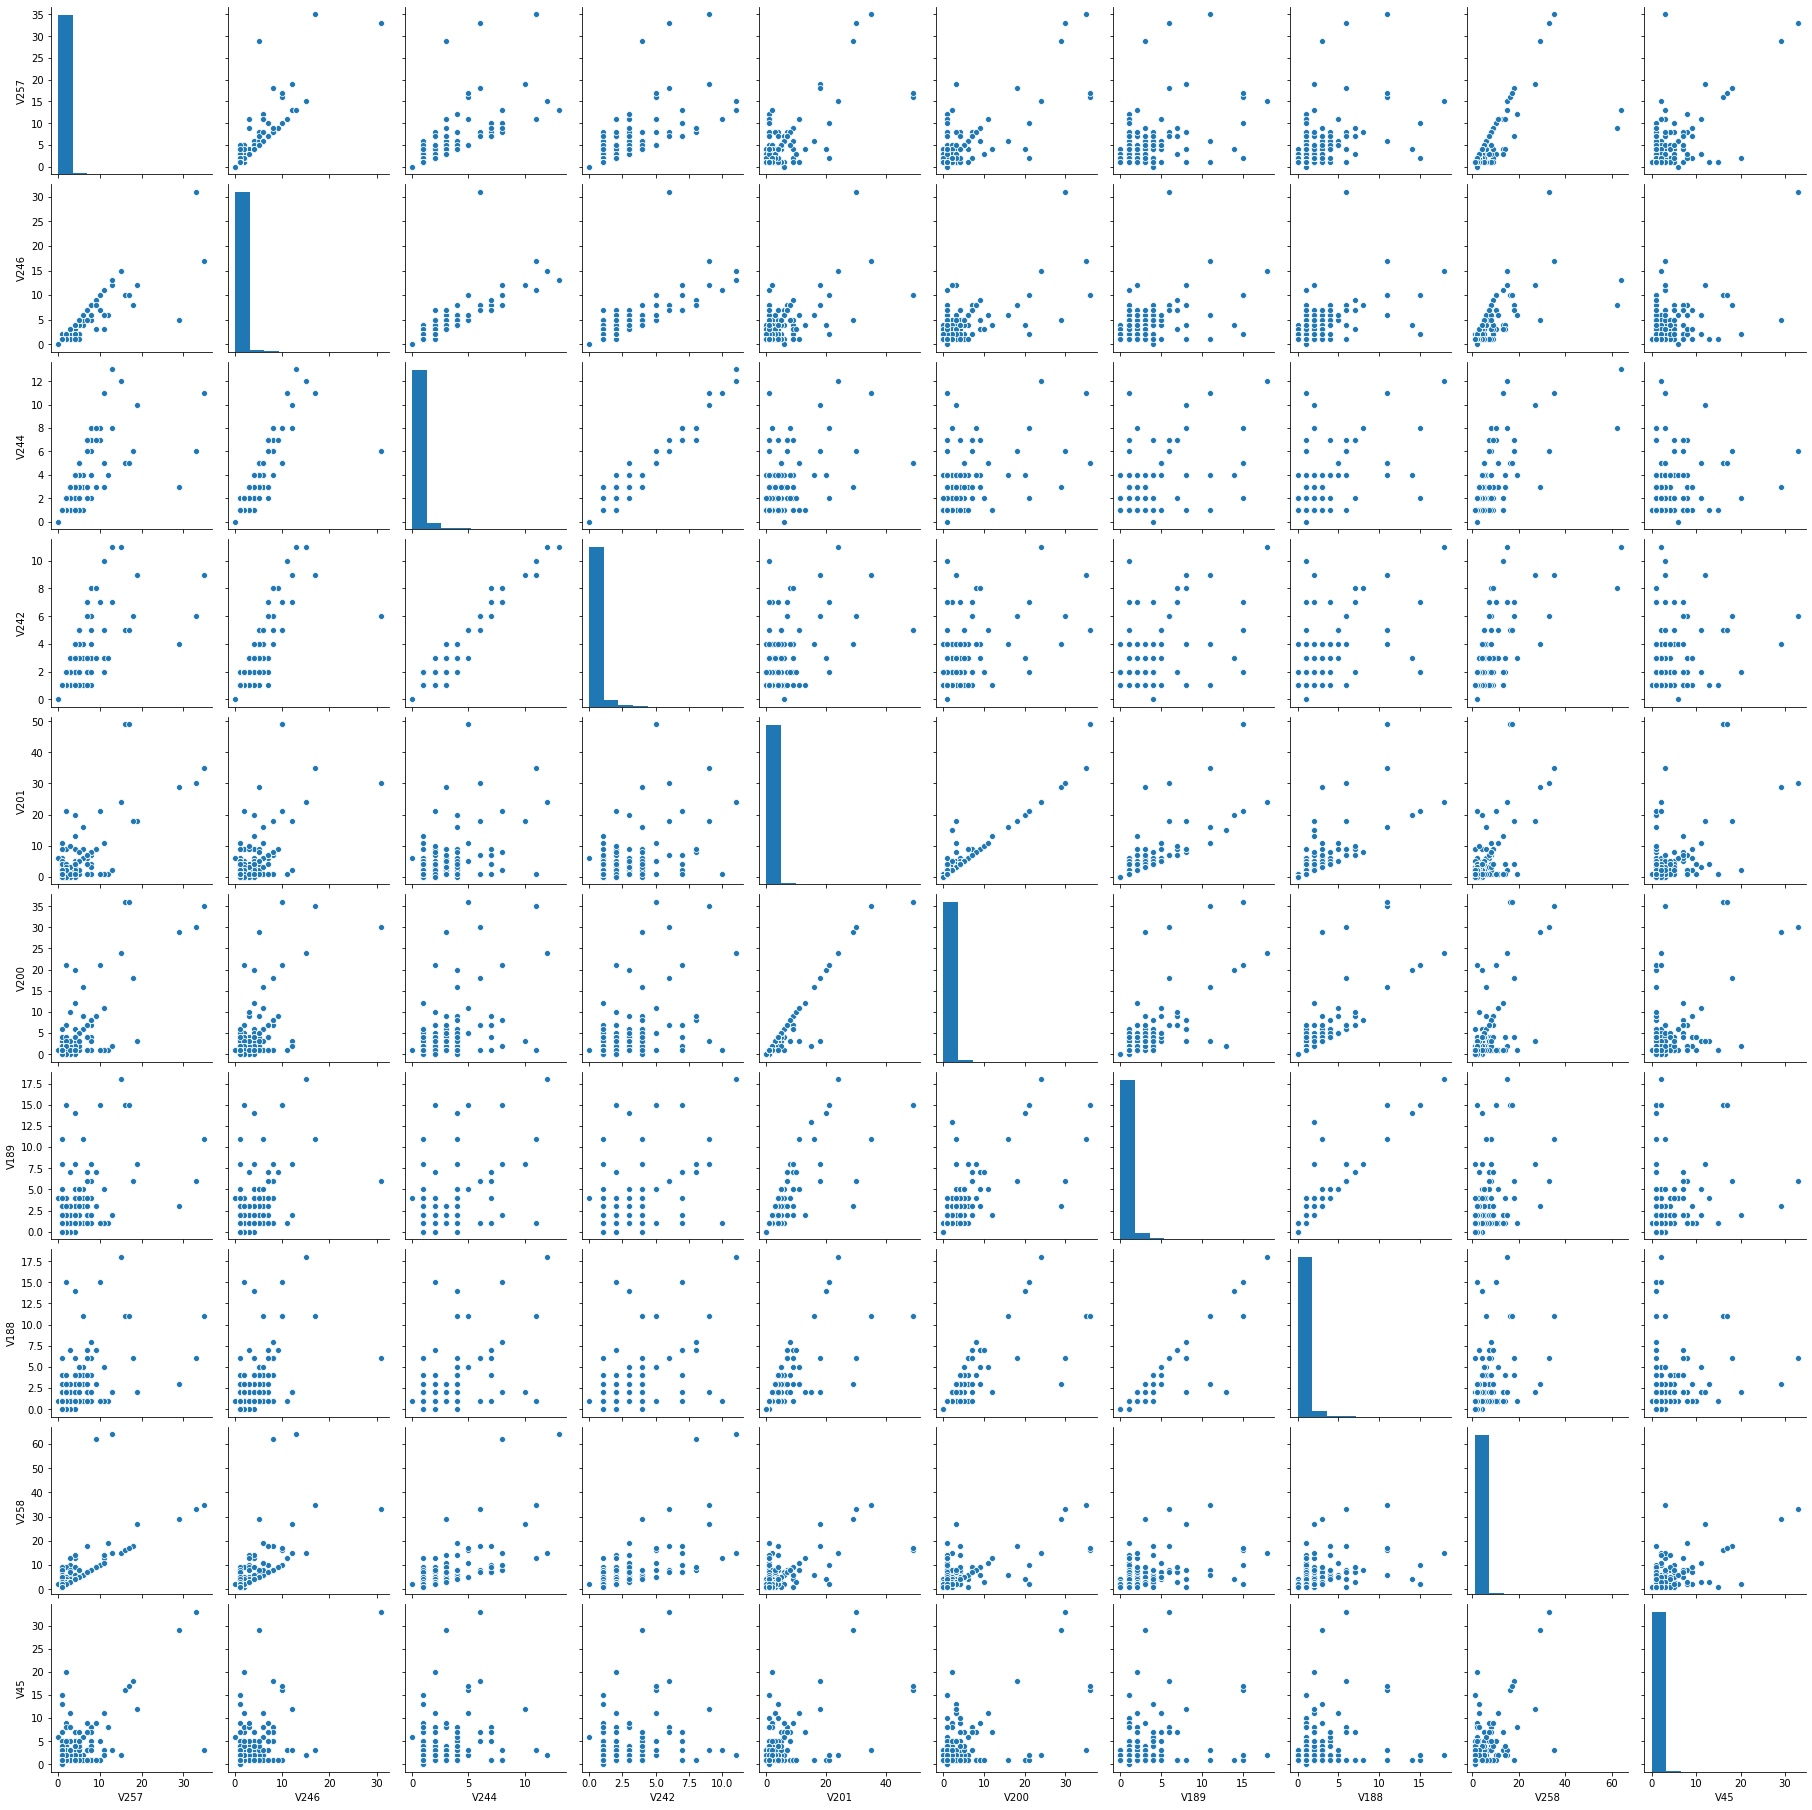

In [18]:
sns.pairplot(t10_corr.sample(20000))

In [19]:
transaction[["isFraud","V144", "V142", ]].dropna(thresh=3).head()

,isFraud,V144,V142
4,0,18.0,0.0
8,0,18.0,0.0
16,0,18.0,0.0
17,0,18.0,0.0
22,0,18.0,0.0


In [20]:
identity

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,...,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,...,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144228,3577521,-15.0,145955.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,chrome 66.0 for android,NaN,NaN,NaN,F,F,T,F,mobile,F3111 Build/33.3.A.1.97
144229,3577526,-5.0,172059.0,NaN,NaN,1.0,-5.0,NaN,NaN,NaN,...,chrome 55.0 for android,32.0,855x480,match_status:2,T,F,T,F,mobile,A574BL Build/NMF26F
144230,3577529,-20.0,632381.0,NaN,NaN,-1.0,-36.0,NaN,NaN,NaN,...,chrome 65.0 for android,NaN,NaN,NaN,F,F,T,F,mobile,Moto E (4) Plus Build/NMA26.42-152
144231,3577531,-5.0,55528.0,0.0,0.0,0.0,-7.0,NaN,NaN,0.0,...,chrome 66.0,24.0,2560x1600,match_status:2,T,F,T,F,desktop,MacOS


In [21]:
transaction.ProductCD.value_counts()

W    439670
C     68519
R     37699
H     33024
S     11628
Name: ProductCD, dtype: int64

In [24]:
transaction[poss_category.query("vals > 15 & vals<20 ").col].head(50)

,V17,V39,V18,V328,V104,V59,V60,V304,V184,V223,V302,V195,V55,V40,V154,V251,V250,V247,V153,V327
0,0.0,NaN,0.0,NaN,0.0,0.0,0.0,0.0,NaN,NaN,0.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,NaN,0.0,NaN,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,NaN,0.0,NaN,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
3,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,NaN,0.0,NaN,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,0.0,0.0,NaN,NaN,1.0,0.0,0.0,1.0,1.0,NaN,NaN,0.0,1.0,1.0,1.0,0.0,0.0
5,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,NaN,0.0,NaN,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
6,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,NaN,0.0,NaN,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
7,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,NaN,0.0,NaN,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,0.0,0.0,NaN,NaN,1.0,0.0,0.0,1.0,1.0,NaN,NaN,0.0,1.0,1.0,1.0,0.0,0.0
9,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,NaN,0.0,NaN,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:

pd.get_dummies(transaction[["M5"]], dummy_na=True, drop_first=True)

,M5_T,M5_nan
0,0,0
1,1,0
2,0,0
3,1,0
4,0,1
...,...,...
590535,1,0
590536,0,0
590537,0,1
590538,0,0


https://chrisalbon.com/code/machine_learning/feature_selection/drop_highly_correlated_features/

In [27]:

# Create correlation matrix
corr_matrix = transaction.sample(10000).corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]




In [28]:
upper[to_drop].head(50)

,TransactionDT,C2,C4,C6,C8,C10,C11,C12,C14,D2,...,V329,V330,V331,V332,V333,V335,V336,V337,V338,V339
TransactionID,0.998273,0.049520,0.055699,0.047096,0.054479,0.057046,0.050101,0.050894,0.040562,0.037757,...,0.224161,0.227284,0.170580,0.202055,0.202902,0.211330,0.148724,0.051407,0.134171,0.097988
isFraud,0.027706,0.046647,0.038292,0.024252,0.039285,0.034248,0.034730,0.039259,0.006138,0.071762,...,0.021314,0.018307,0.019760,0.021855,0.022114,0.014449,0.010755,0.006924,0.012680,0.008397
TransactionDT,NaN,0.045926,0.051957,0.043893,0.050712,0.053175,0.046704,0.047233,0.037791,0.037760,...,0.231372,0.234691,0.175714,0.208529,0.209314,0.217027,0.154282,0.051454,0.137272,0.099744
TransactionAmt,NaN,0.019511,0.009464,0.019564,0.012946,0.013544,0.018963,0.014867,0.027218,0.002916,...,0.001689,0.014616,0.098349,0.057970,0.080972,0.062612,0.127064,0.216844,0.188800,0.208191
card1,NaN,0.007055,0.003807,0.006342,0.006987,0.007675,0.007014,0.008585,0.006644,0.023402,...,0.121734,0.126375,0.098841,0.118466,0.119348,0.102140,0.087626,0.022665,0.074086,0.052484
card2,NaN,0.003561,0.005414,0.000259,0.004416,0.003195,0.003112,0.002748,0.000387,0.011958,...,0.073509,0.074818,0.027800,0.045433,0.041369,0.047667,0.034235,0.028878,0.000921,0.013662
card3,NaN,0.071484,0.070852,0.041534,0.078899,0.079398,0.055320,0.083954,0.018584,0.056320,...,0.001561,0.003726,0.002951,0.003511,0.003616,0.006739,0.006858,0.002112,0.000298,0.000938
card5,NaN,0.006181,0.011951,0.002495,0.011849,0.010520,0.002504,0.011278,0.007781,0.098031,...,0.251028,0.255997,0.199998,0.233012,0.235954,0.249092,0.215336,0.060266,0.155506,0.114091
addr1,NaN,0.007275,0.008575,0.006001,0.010556,0.010922,0.005847,0.013017,0.002940,0.006198,...,0.044070,0.045817,0.034953,0.039831,0.040610,0.043702,0.038778,0.011333,0.028526,0.021571
addr2,NaN,0.062556,0.055935,0.031076,0.099930,0.109311,0.044466,0.136171,0.015823,0.000811,...,0.000075,0.002376,0.002820,0.002880,0.002969,0.006656,0.007959,0.000383,0.001327,0.000816


In [30]:
def print_categorical(df):
    for c in df:
        if len(df[c].unique()) <= 50:
            print(c)
            print(df[c].value_counts(dropna=False).sort_index())
#print_categorical(transaction)

In [31]:
print_categorical(identity)

id_03
-13.0        3
-12.0        3
-11.0        6
-10.0       17
-9.0         6
-8.0        14
-7.0        21
-6.0        31
-5.0        33
-4.0        21
-3.0         8
-2.0        12
-1.0        12
 0.0     63903
 1.0       863
 2.0       421
 3.0       668
 4.0       100
 5.0       109
 6.0        64
 7.0         4
 8.0         1
 9.0         3
 10.0        1
 NaN     77909
Name: id_03, dtype: int64
id_04
-28.0        2
-13.0       24
-12.0       34
-11.0       35
-10.0       30
-9.0        26
-8.0        64
-7.0        21
-6.0        98
-5.0       132
-4.0        51
-3.0        10
-2.0        15
-1.0        43
 0.0     65739
 NaN     77909
Name: id_04, dtype: int64
id_09
-36.0        1
-31.0        3
-30.0        1
-26.0        2
-24.0        1
-23.0        4
-22.0        4
-21.0        3
-20.0        1
-19.0        2
-18.0        2
-17.0        4
-15.0        2
-14.0        1
-13.0        4
-12.0        4
-11.0       18
-10.0       39
-9.0        27
-8.0        37
-7.0        39


In [33]:
obj_cols = transaction.select_dtypes("object")


In [34]:
obj_cols["ProductCD"].value_counts(dropna=False)

W    439670
C     68519
R     37699
H     33024
S     11628
Name: ProductCD, dtype: int64

In [35]:
dummies = []
dummies.append(pd.get_dummies(obj_cols["ProductCD"], prefix="PrdCD"))


In [36]:
obj_cols.card4.value_counts(dropna=False)

visa                384767
mastercard          189217
american express      8328
discover              6651
NaN                   1577
Name: card4, dtype: int64

In [37]:
crd4 = pd.get_dummies(obj_cols.card4, prefix='crd4', dummy_na=True)
crd4.columns= [name[:8] for name in crd4.columns]

https://towardsdatascience.com/visualizing-the-nothing-ae6daccc9197

In [38]:
dummies.append(crd4)


In [39]:
obj_cols.card6.replace({"debit or credit": "other", "charge card":"other"}).value_counts(dropna=False)

debit     439938
credit    148986
NaN         1571
other         45
Name: card6, dtype: int64

In [40]:
dummies.append(pd.get_dummies(obj_cols.card6.replace({"debit or credit": "other", "charge card":"other"}), dummy_na=True))

In [41]:
obj_cols.P_emaildomain.value_counts(dropna=False)


gmail.com           228355
yahoo.com           100934
NaN                  94456
hotmail.com          45250
anonymous.com        36998
aol.com              28289
comcast.net           7888
icloud.com            6267
outlook.com           5096
msn.com               4092
att.net               4033
live.com              3041
sbcglobal.net         2970
verizon.net           2705
ymail.com             2396
bellsouth.net         1909
yahoo.com.mx          1543
me.com                1522
cox.net               1393
optonline.net         1011
charter.net            816
live.com.mx            749
rocketmail.com         664
mail.com               559
earthlink.net          514
gmail                  496
outlook.es             438
mac.com                436
juno.com               322
aim.com                315
roadrunner.com         305
windstream.net         305
hotmail.es             305
hotmail.fr             295
frontier.com           280
embarqmail.com         260
web.de                 240
n

In [42]:
split_email = obj_cols.P_emaildomain.str.split("\.", n=1, expand=True)


split_email

,0,1
0,NaN,NaN
1,gmail,com
2,outlook,com
3,yahoo,com
4,gmail,com
...,...,...
590535,NaN,NaN
590536,gmail,com
590537,gmail,com
590538,aol,com


In [43]:
split_email[0].value_counts()

gmail           228851
yahoo           102909
hotmail          46005
anonymous        36998
aol              28289
comcast           7888
icloud            6267
outlook           5534
msn               4092
att               4033
live              3846
sbcglobal         2970
verizon           2705
ymail             2396
bellsouth         1909
me                1522
cox               1393
optonline         1011
charter            816
rocketmail         664
mail               559
earthlink          514
mac                436
netzero            426
juno               322
aim                315
windstream         305
roadrunner         305
frontier           280
embarqmail         260
web                240
twc                230
prodigy            207
centurylink        205
frontiernet        195
q                  189
suddenlink         175
cfl                172
sc                 164
cableone           159
gmx                149
protonmail          76
ptd                 68
servicios-t

In [44]:
split_email[1].value_counts()

com       466141
net        24542
com.mx      2292
es           877
de           506
fr           494
rr.com       336
net.mx       207
co.uk        161
co.jp         32
Name: 1, dtype: int64

In [45]:
dummies.append(pd.get_dummies(obj_cols.P_emaildomain.str.split("\.", n=1, expand=True), prefix="P_eml_", dummy_na=True))

In [46]:
obj_cols.R_emaildomain.value_counts(dropna=False)

NaN                453249
gmail.com           57147
hotmail.com         27509
anonymous.com       20529
yahoo.com           11842
                    ...  
netzero.com            14
frontiernet.net        14
centurylink.net        12
netzero.net             9
sc.rr.com               8
Name: R_emaildomain, Length: 61, dtype: int64

In [47]:
split_email = obj_cols.R_emaildomain.str.split("\.", n=1, expand=True)
split_email

,0,1
0,NaN,NaN
1,NaN,NaN
2,NaN,NaN
3,NaN,NaN
4,NaN,NaN
...,...,...
590535,NaN,NaN
590536,NaN,NaN
590537,NaN,NaN
590538,NaN,NaN


In [48]:
split_email[0].value_counts(dropna=False), split_email[1].value_counts(dropna=False), 

(NaN             453249
 gmail            57242
 hotmail          28241
 anonymous        20529
 yahoo            13691
 aol               3701
 outlook           2940
 comcast           1812
 live              1571
 icloud            1398
 msn                852
 verizon            620
 me                 556
 sbcglobal          552
 cox                459
 att                430
 bellsouth          422
 web                237
 mac                218
 ymail              207
 prodigy            207
 optonline          187
 gmx                147
 charter            127
 mail               122
 earthlink           79
 rocketmail          69
 embarqmail          68
 scranton            63
 roadrunner          53
 juno                53
 frontier            52
 windstream          47
 protonmail          41
 cfl                 37
 aim                 36
 servicios-ta        35
 twc                 29
 ptd                 27
 cableone            27
 suddenlink          25
 q              

In [49]:
counts = split_email[0].value_counts()

In [50]:
clean_email_mapper = {prefix:"other" for prefix in counts[counts<=40].index}
clean_email_mapper


{'cfl': 'other',
 'aim': 'other',
 'servicios-ta': 'other',
 'twc': 'other',
 'ptd': 'other',
 'cableone': 'other',
 'suddenlink': 'other',
 'q': 'other',
 'netzero': 'other',
 'frontiernet': 'other',
 'centurylink': 'other',
 'sc': 'other'}

In [51]:
split_email[0] = split_email[0].replace(clean_email_mapper)

In [52]:
dummies.append(pd.get_dummies(split_email, prefix="R_eml", dummy_na=True))

In [53]:
for c in obj_cols.loc[:,"M1":]:
    print(obj_cols[c].value_counts(dropna=False))

T      319415
NaN    271100
F          25
Name: M1, dtype: int64
T      285468
NaN    271100
F       33972
Name: M2, dtype: int64
NaN    271100
T      251731
F       67709
Name: M3, dtype: int64
NaN    281444
M0     196405
M2      59865
M1      52826
Name: M4, dtype: int64
NaN    350482
F      132491
T      107567
Name: M5, dtype: int64
F      227856
T      193324
NaN    169360
Name: M6, dtype: int64
NaN    346265
F      211374
T       32901
Name: M7, dtype: int64
NaN    346252
F      155251
T       89037
Name: M8, dtype: int64
NaN    346252
T      205656
F       38632
Name: M9, dtype: int64


In [54]:
dummies.append(pd.get_dummies(obj_cols.loc[:,"M1":], dummy_na=True, drop_first=True))

In [55]:
pd.concat(dummies, axis=1).to_csv("transaction_obj_dummies.csv")

In [56]:
dummies = pd.concat(dummies, axis=1)

In [57]:
transaction=transaction.drop(columns=[x for x in obj_cols.columns])

In [58]:
ids = transaction.TransactionID
transaction=transaction.drop(columns=["TransactionID"])

In [59]:
labels = transaction.isFraud
transaction=transaction.drop(columns=["isFraud"])

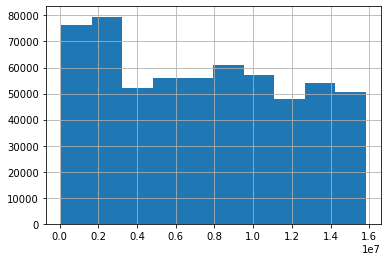

In [60]:
transaction.TransactionDT.hist()

In [61]:
unsure = transaction.TransactionDT.to_frame()
unsure

,TransactionDT
0,86400
1,86401
2,86469
3,86499
4,86506
...,...
590535,15811047
590536,15811049
590537,15811079
590538,15811088


In [62]:
transaction = transaction.drop(columns=["TransactionDT"])

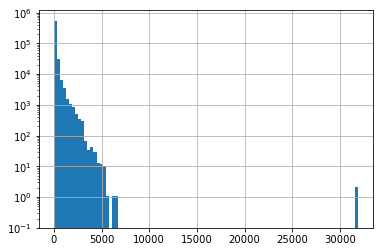

In [63]:

fig, ax = plt.subplots()
transaction.TransactionAmt.hist(ax=ax, bins=100, bottom=0.1)
ax.set_yscale('log')
#ax.set_xscale('log')

In [64]:
cut = pd.qcut(transaction.TransactionAmt, 10)

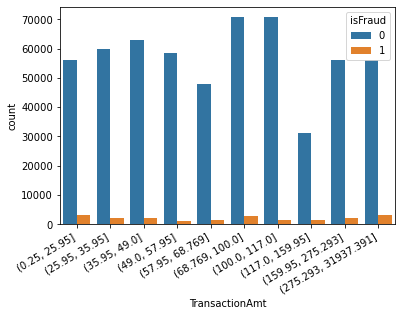

In [65]:
fig, ax = plt.subplots()
sns.countplot(cut, hue=labels)
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.show()


In [66]:
foo = pd.DataFrame()
foo['L']=labels
foo["C"]=cut

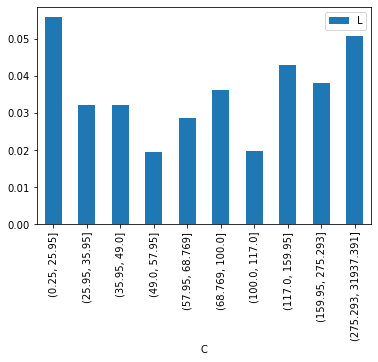

In [67]:
foo.groupby("C").mean().plot(kind="bar")

In [68]:
continuous = transaction.TransactionAmt
transaction= transaction.drop(columns=["TransactionAmt"])

In [69]:
transaction.card1.value_counts(dropna=False)

7919     14932
9500     14162
15885    10361
17188    10344
15066     7945
         ...  
12390        1
10341        1
10006        1
15743        1
17105        1
Name: card1, Length: 13553, dtype: int64

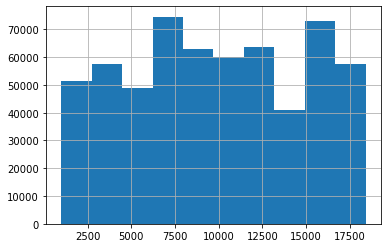

In [70]:
transaction.card1.hist()

In [71]:
unsure["card1"] = transaction.card1

In [72]:
transaction=transaction.drop(columns="card1")

In [73]:
transaction.card2.value_counts(dropna=False)

321.0    48935
111.0    45191
555.0    41995
490.0    38145
583.0    21803
         ...  
447.0       39
153.0       38
557.0       37
473.0       18
582.0       14
Name: card2, Length: 501, dtype: int64

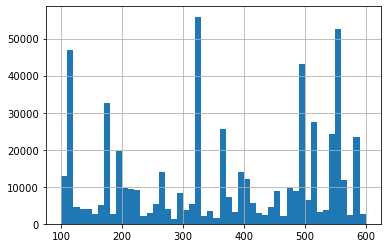

In [74]:
transaction.card2.hist(bins=50)

In [75]:
foo = pd.concat([labels, pd.qcut(transaction.card2, 17)], axis=1)

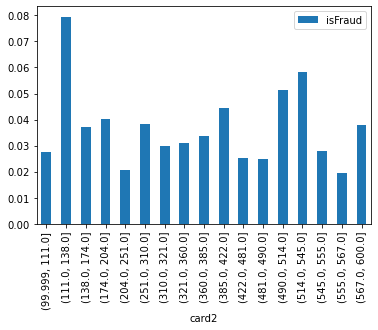

In [76]:
foo.groupby("card2").mean().plot(kind="bar")

In [77]:
unsure["card2"] = transaction.card2

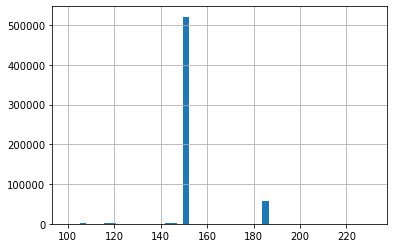

In [78]:
transaction.card3.hist(bins=50)

In [79]:
guess_if_categorical(transaction.card3)

{'integers': False,
 'zero_one': True,
 'is_linspace_unique': False,
 'has_limited_entries(arr)': False}

In [80]:
unsure["card3"] = transaction.card3

transaction = transaction.drop(columns=["card1","card2", "card3"])

KeyError: "['card1'] not found in axis"

In [ ]:
guess_if_categorical(transaction.card5)

In [ ]:
c = pd.qcut(transaction.card5, 30, duplicates='drop')
foo=pd.concat([c, labels], axis=1)

In [ ]:
sns.countplot(x="card5",data=foo, hue="isFraud", )

In [ ]:
unsure['card5']=transaction.card5

In [ ]:
transaction.drop(columns="card5")

In [81]:
guess_if_categorical(transaction.addr1)

{'integers': False,
 'zero_one': True,
 'is_linspace_unique': False,
 'has_limited_entries(arr)': False}

In [82]:
transaction.addr1.value_counts(dropna=False).head(50)

NaN      65706
299.0    46335
325.0    42751
204.0    42020
264.0    39870
330.0    26287
315.0    23078
441.0    20827
272.0    20141
123.0    16105
126.0    15243
184.0    15160
337.0    15149
191.0    14979
181.0    13856
143.0     9806
476.0     9478
310.0     8486
472.0     8478
327.0     8425
512.0     8268
387.0     8187
433.0     7831
231.0     7605
485.0     6816
269.0     6404
205.0     5725
225.0     5323
251.0     5216
494.0     5065
220.0     5041
226.0     4867
498.0     4744
177.0     4674
203.0     3808
420.0     3581
110.0     3220
436.0     3169
469.0     2940
324.0     2173
444.0     2033
170.0     2001
343.0     1734
384.0     1670
122.0     1617
194.0     1572
158.0     1562
428.0     1425
308.0     1279
253.0     1058
Name: addr1, dtype: int64

In [83]:
transaction.addr2.value_counts(dropna=False).head(50)

87.0     520481
NaN       65706
60.0       3084
96.0        638
32.0         91
65.0         82
16.0         55
31.0         47
19.0         33
26.0         25
27.0         20
59.0         17
69.0         17
34.0         16
43.0         12
102.0        11
29.0         11
98.0         11
68.0         10
57.0         10
78.0          8
10.0          8
13.0          7
71.0          7
17.0          7
72.0          6
54.0          6
88.0          5
52.0          5
73.0          5
21.0          5
51.0          4
28.0          4
48.0          4
47.0          4
30.0          4
62.0          4
101.0         4
61.0          3
18.0          3
46.0          3
44.0          3
39.0          3
38.0          3
40.0          3
24.0          3
20.0          3
74.0          3
100.0         2
92.0          2
Name: addr2, dtype: int64

In [84]:
transaction.dist1.value_counts().head(50)

0.0     19824
1.0     18330
2.0     17028
4.0     13067
3.0     12808
5.0     12004
6.0      9843
7.0      9340
8.0      7731
9.0      7728
10.0     6288
11.0     6047
12.0     5384
14.0     4603
13.0     4559
15.0     3451
16.0     3390
18.0     2818
17.0     2766
19.0     2429
21.0     2243
20.0     2097
22.0     1968
24.0     1738
23.0     1721
26.0     1491
25.0     1428
27.0     1201
28.0     1161
29.0     1010
32.0      947
33.0      910
30.0      881
31.0      685
36.0      649
34.0      630
35.0      630
40.0      587
45.0      523
38.0      505
37.0      492
42.0      445
41.0      436
43.0      425
54.0      420
39.0      416
44.0      388
50.0      388
48.0      375
46.0      365
Name: dist1, dtype: int64

In [85]:
continuous=continuous.to_frame()



In [86]:

continuous['dist1'] = transaction.dist1

In [87]:
foo = pd.concat([transaction.dist2, labels],axis=1)


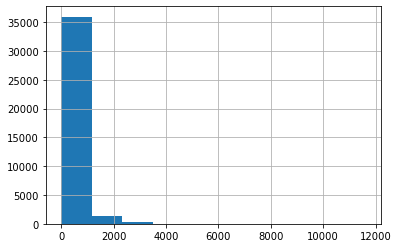

In [88]:
transaction.dist2.hist()

In [89]:
continuous['dist2'] = transaction.dist2

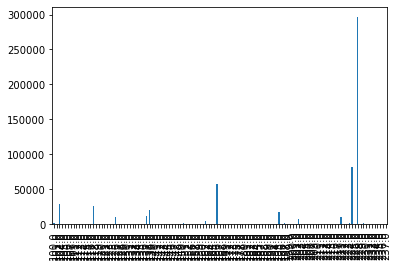

In [100]:
transaction.card5.value_counts().sort_index().plot(kind="bar")

In [101]:
unsure["card5"] = transaction.card5

In [92]:
continuous

,TransactionAmt,dist1,dist2
0,68.50,19.0,NaN
1,29.00,NaN,NaN
2,59.00,287.0,NaN
3,50.00,NaN,NaN
4,50.00,NaN,NaN
...,...,...,...
590535,49.00,48.0,NaN
590536,39.50,NaN,NaN
590537,30.95,NaN,NaN
590538,117.00,3.0,NaN


In [94]:
dummies

,PrdCD_C,PrdCD_H,PrdCD_R,PrdCD_S,PrdCD_W,crd4_ame,crd4_dis,crd4_mas,crd4_vis,crd4_nan,...,M5_T,M5_nan,M6_T,M6_nan,M7_T,M7_nan,M8_T,M8_nan,M9_T,M9_nan
0,0,0,0,0,1,0,1,0,0,0,...,0,0,1,0,0,1,0,1,0,1
1,0,0,0,0,1,0,0,1,0,0,...,1,0,1,0,0,1,0,1,0,1
2,0,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,1,0,0,...,1,0,0,0,0,1,0,1,0,1
4,0,1,0,0,0,0,0,1,0,0,...,0,1,0,1,0,1,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590535,0,0,0,0,1,0,0,0,1,0,...,1,0,0,0,0,0,0,0,1,0
590536,0,0,0,0,1,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
590537,0,0,0,0,1,0,0,1,0,0,...,0,1,1,0,0,1,0,1,0,1
590538,0,0,0,0,1,0,0,1,0,0,...,0,0,1,0,0,1,0,1,0,1


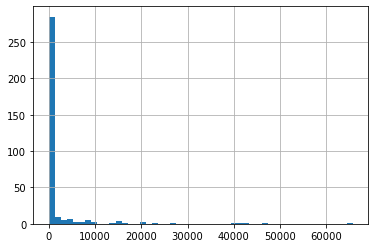

In [108]:
transaction.addr1.value_counts(dropna=False).sort_index().hist(bins=50)

In [111]:
foo = transaction.addr1.value_counts(dropna=False)

In [150]:
dummies = pd.concat([dummies, pd.get_dummies(transaction.addr1.replace(foo[foo<50].index, -99),prefix="adr1_", dummy_na=True, drop_first=True)], axis=1)

In [148]:
foo = transaction.addr2.value_counts(dropna=False)
dummies = pd.concat([dummies,pd.get_dummies(transaction.addr2.replace(foo[foo<50].index, -99),prefix="adr2_", dummy_na=True, drop_first=True)], axis=1)
dummies

,PrdCD_C,PrdCD_H,PrdCD_R,PrdCD_S,PrdCD_W,crd4_ame,crd4_dis,crd4_mas,crd4_vis,crd4_nan,...,M8_nan,M9_T,M9_nan,adr2__16.0,adr2__32.0,adr2__60.0,adr2__65.0,adr2__87.0,adr2__96.0,adr2__nan
0,0,0,0,0,1,0,1,0,0,0,...,1,0,1,0,0,0,0,1,0,0
1,0,0,0,0,1,0,0,1,0,0,...,1,0,1,0,0,0,0,1,0,0
2,0,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,1,0,0,1,0,0,...,1,0,1,0,0,0,0,1,0,0
4,0,1,0,0,0,0,0,1,0,0,...,1,0,1,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590535,0,0,0,0,1,0,0,0,1,0,...,0,1,0,0,0,0,0,1,0,0
590536,0,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
590537,0,0,0,0,1,0,0,1,0,0,...,1,0,1,0,0,0,0,1,0,0
590538,0,0,0,0,1,0,0,1,0,0,...,1,0,1,0,0,0,0,1,0,0


In [142]:
pd.concat([dummies, pd.get_dummies(transaction.addr2.replace(foo[foo<100].index, -99),prefix="adr2_", dummy_na=True, drop_first=True)], axis=1)

,PrdCD_C,PrdCD_H,PrdCD_R,PrdCD_S,PrdCD_W,crd4_ame,crd4_dis,crd4_mas,crd4_vis,crd4_nan,...,M7_T,M7_nan,M8_T,M8_nan,M9_T,M9_nan,adr2__60.0,adr2__87.0,adr2__96.0,adr2__nan
0,0,0,0,0,1,0,1,0,0,0,...,0,1,0,1,0,1,0,1,0,0
1,0,0,0,0,1,0,0,1,0,0,...,0,1,0,1,0,1,0,1,0,0
2,0,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,1,0,0,1,0,0,...,0,1,0,1,0,1,0,1,0,0
4,0,1,0,0,0,0,0,1,0,0,...,0,1,0,1,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590535,0,0,0,0,1,0,0,0,1,0,...,0,0,0,0,1,0,0,1,0,0
590536,0,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
590537,0,0,0,0,1,0,0,1,0,0,...,0,1,0,1,0,1,0,1,0,0
590538,0,0,0,0,1,0,0,1,0,0,...,0,1,0,1,0,1,0,1,0,0


In [145]:
dummies.columns

Index([ 'PrdCD_C',  'PrdCD_H',  'PrdCD_R',  'PrdCD_S',  'PrdCD_W', 'crd4_ame',
       'crd4_dis', 'crd4_mas', 'crd4_vis', 'crd4_nan',
       ...
           'M5_T',   'M5_nan',     'M6_T',   'M6_nan',     'M7_T',   'M7_nan',
           'M8_T',   'M8_nan',     'M9_T',   'M9_nan'],
      dtype='object', length=136)

In [159]:
transaction = transaction.drop(columns=["card2", "card3", "card5", "addr1", "addr2", "dist1", "dist2"])

In [165]:
c_cols = transaction.filter(like="C", )

In [166]:
for c in c_cols:
    print(c, guess_if_categorical(c_cols[c]))

C1 {'integers': True, 'zero_one': True, 'is_linspace_unique': False, 'has_limited_entries(arr)': False}
C2 {'integers': True, 'zero_one': True, 'is_linspace_unique': False, 'has_limited_entries(arr)': False}
C3 True
C4 {'integers': True, 'zero_one': True, 'is_linspace_unique': False, 'has_limited_entries(arr)': False}
C5 {'integers': True, 'zero_one': True, 'is_linspace_unique': False, 'has_limited_entries(arr)': False}
C6 {'integers': True, 'zero_one': True, 'is_linspace_unique': False, 'has_limited_entries(arr)': False}
C7 {'integers': True, 'zero_one': True, 'is_linspace_unique': False, 'has_limited_entries(arr)': False}
C8 {'integers': True, 'zero_one': True, 'is_linspace_unique': False, 'has_limited_entries(arr)': False}
C9 {'integers': True, 'zero_one': True, 'is_linspace_unique': False, 'has_limited_entries(arr)': False}
C10 {'integers': True, 'zero_one': True, 'is_linspace_unique': False, 'has_limited_entries(arr)': False}
C11 {'integers': True, 'zero_one': True, 'is_linspace_u

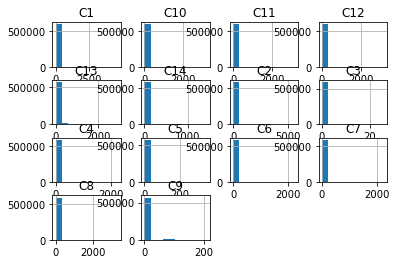

In [184]:
c_cols.hist()
plt.xscale("log")
plt.show()


In [196]:
c_cols.corr()

,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14
C1,1.000000,0.995089,-0.003467,0.967800,0.165862,0.982238,0.926258,0.967746,0.175999,0.958202,0.996515,0.927939,0.774603,0.951761
C2,0.995089,1.000000,-0.003339,0.972134,0.126540,0.974845,0.938867,0.975863,0.133566,0.970624,0.993898,0.940258,0.751221,0.936148
C3,-0.003467,-0.003339,1.000000,-0.001720,-0.008101,-0.004711,-0.001730,-0.001203,-0.010074,-0.001494,-0.003583,-0.001763,-0.007747,-0.005091
C4,0.967800,0.972134,-0.001720,1.000000,-0.012842,0.962319,0.895092,0.959995,-0.015970,0.952466,0.974547,0.894619,0.644549,0.907676
C5,0.165862,0.126540,-0.008101,-0.012842,1.000000,0.232409,-0.009970,-0.011654,0.925786,-0.011846,0.168862,-0.009875,0.717509,0.378950
C6,0.982238,0.974845,-0.004711,0.962319,0.232409,1.000000,0.858583,0.921972,0.250695,0.914440,0.991105,0.858182,0.808531,0.984201
C7,0.926258,0.938867,-0.001730,0.895092,-0.009970,0.858583,1.000000,0.982983,-0.012399,0.985062,0.915209,0.999489,0.632394,0.794701
C8,0.967746,0.975863,-0.001203,0.959995,-0.011654,0.921972,0.982983,1.000000,-0.014492,0.996970,0.962722,0.983027,0.653245,0.860246
C9,0.175999,0.133566,-0.010074,-0.015970,0.925786,0.250695,-0.012399,-0.014492,1.000000,-0.014731,0.182446,-0.012212,0.704056,0.397396
C10,0.958202,0.970624,-0.001494,0.952466,-0.011846,0.914440,0.985062,0.996970,-0.014731,1.000000,0.956056,0.983817,0.653941,0.853009


In [187]:
c_cols.corr().mask(lambda x:x<0.9)

,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14
C1,1.000000,0.995089,NaN,0.967800,NaN,0.982238,0.926258,0.967746,NaN,0.958202,0.996515,0.927939,NaN,0.951761
C2,0.995089,1.000000,NaN,0.972134,NaN,0.974845,0.938867,0.975863,NaN,0.970624,0.993898,0.940258,NaN,0.936148
C3,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
C4,0.967800,0.972134,NaN,1.000000,NaN,0.962319,NaN,0.959995,NaN,0.952466,0.974547,NaN,NaN,0.907676
C5,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,0.925786,NaN,NaN,NaN,NaN,NaN
C6,0.982238,0.974845,NaN,0.962319,NaN,1.000000,NaN,0.921972,NaN,0.914440,0.991105,NaN,NaN,0.984201
C7,0.926258,0.938867,NaN,NaN,NaN,NaN,1.000000,0.982983,NaN,0.985062,0.915209,0.999489,NaN,NaN
C8,0.967746,0.975863,NaN,0.959995,NaN,0.921972,0.982983,1.000000,NaN,0.996970,0.962722,0.983027,NaN,NaN
C9,NaN,NaN,NaN,NaN,0.925786,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN
C10,0.958202,0.970624,NaN,0.952466,NaN,0.914440,0.985062,0.996970,NaN,1.000000,0.956056,0.983817,NaN,NaN


In [194]:
c_cols.describe()

,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14
count,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000
mean,14.092458,15.269734,0.005644,4.092185,5.571526,9.071082,2.848478,5.144574,4.480240,5.240343,10.241521,4.076227,32.539918,8.295215
std,133.569018,154.668899,0.150536,68.848459,25.786976,71.508467,61.727304,95.378574,16.674897,95.581443,94.336292,86.666218,129.364844,49.544262
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000
50%,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,3.000000,1.000000
75%,3.000000,3.000000,0.000000,0.000000,1.000000,2.000000,0.000000,0.000000,2.000000,0.000000,2.000000,0.000000,12.000000,2.000000
max,4685.000000,5691.000000,26.000000,2253.000000,349.000000,2253.000000,2255.000000,3331.000000,210.000000,3257.000000,3188.000000,3188.000000,2918.000000,1429.000000


## PCA on C fields

In [207]:
#not sure if good idea
from sklearn.decomposition import PCA
c_cols = transaction.filter(like="C", )
c_scaled = c_cols.apply(lambda x: (x-x.mean())/x.std())
pca = PCA("mle")
c_reduced = pca.fit_transform(c_scaled)


y_ax=pca.explained_variance_ratio_.round(3)*100

# Create a plot
plt.figure(figsize=(10,8), dpi=300)
plt.bar(x=range(c_reduced.shape[1]), height=y_ax, color='black')

# Annotate chart by adding values on top of the bars
for i in range(c_reduced.shape[1]):
    plt.text(i,y_ax[i]+0.2,str(y_ax[i].round(3))+'%', ha = 'center')

# Set title for chart and axis        
plt.title(label='PCA Variance Explained', loc='center')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance (%)')
plt.show()



In [208]:
continuous = pd.concat([continuous, c_cols], axis=1)

In [302]:
d_cols = transaction.filter(like="D")
for c in d_cols:
    print(c, guess_if_categorical(d_cols[c]))

D1 {'integers': True, 'zero_one': True, 'is_linspace_unique': False, 'has_limited_entries(arr)': False}
D2 {'integers': True, 'zero_one': True, 'is_linspace_unique': False, 'has_limited_entries(arr)': False}
D3 {'integers': True, 'zero_one': True, 'is_linspace_unique': False, 'has_limited_entries(arr)': False}
D4 {'integers': True, 'zero_one': True, 'is_linspace_unique': False, 'has_limited_entries(arr)': False}
D5 {'integers': True, 'zero_one': True, 'is_linspace_unique': False, 'has_limited_entries(arr)': False}
D6 {'integers': True, 'zero_one': True, 'is_linspace_unique': False, 'has_limited_entries(arr)': False}
D7 {'integers': True, 'zero_one': True, 'is_linspace_unique': False, 'has_limited_entries(arr)': False}
D8 {'integers': False, 'zero_one': True, 'is_linspace_unique': False, 'has_limited_entries(arr)': False}
D9 {'integers': False, 'zero_one': True, 'is_linspace_unique': False, 'has_limited_entries(arr)': False}
D10 {'integers': True, 'zero_one': True, 'is_linspace_unique':

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002602B7F13A0>,
      dtype=object)

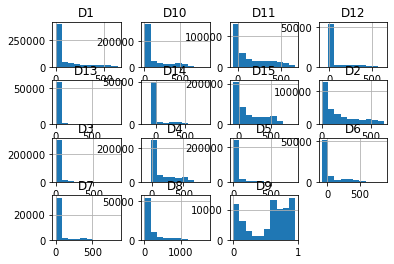

In [175]:
d_cols.hist()

In [179]:
corr = d_cols.corr()
corr.mask(lambda x: x<.9)

,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15
D1,1.000000,0.981311,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
D2,0.981311,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
D3,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
D4,NaN,NaN,NaN,1.000000,NaN,0.956966,NaN,NaN,NaN,NaN,NaN,0.999999,NaN,NaN,NaN
D5,NaN,NaN,NaN,NaN,1.000000,NaN,0.986496,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
D6,NaN,NaN,NaN,0.956966,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,0.976834,NaN,NaN,NaN
D7,NaN,NaN,NaN,NaN,0.986496,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
D8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
D9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
D10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN


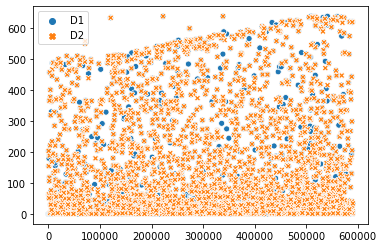

In [226]:
sns.scatterplot(data=d_cols[["D1", "D2"]].sample(5000))


In [232]:
v_cols = transaction.loc[:,"V1":]

In [314]:
true_list = []
for col in v_cols:
    cat = guess_if_categorical(v_cols[col])
    if cat is True:
        print(col)
        true_list.append(col)
    else:
        print(cat)

V1
V2
V3
V4
V5
V6
V7
V8
V9
V10
V11
V12
V13
V14
V15
{'integers': True, 'zero_one': True, 'is_linspace_unique': False, 'has_limited_entries(arr)': True}
V17
V18
V19
{'integers': True, 'zero_one': True, 'is_linspace_unique': False, 'has_limited_entries(arr)': True}
V21
V22
V23
V24
{'integers': True, 'zero_one': True, 'is_linspace_unique': False, 'has_limited_entries(arr)': True}
{'integers': True, 'zero_one': True, 'is_linspace_unique': False, 'has_limited_entries(arr)': True}
{'integers': True, 'zero_one': True, 'is_linspace_unique': False, 'has_limited_entries(arr)': True}
{'integers': True, 'zero_one': True, 'is_linspace_unique': False, 'has_limited_entries(arr)': True}
V29
{'integers': True, 'zero_one': True, 'is_linspace_unique': False, 'has_limited_entries(arr)': True}
V31
{'integers': True, 'zero_one': True, 'is_linspace_unique': False, 'has_limited_entries(arr)': True}
{'integers': True, 'zero_one': True, 'is_linspace_unique': False, 'has_limited_entries(arr)': True}
{'integers': 

In [271]:
v_cols.V1.value_counts(dropna=False)

1.0    311236
NaN    279287
0.0        17
Name: V1, dtype: int64

In [274]:
is_integers([1, np.NaN, 5.0])

<ipython-input-255-517dd4fa2e32>:19: RuntimeWarning: invalid value encountered in remainder
  return np.equal(np.mod(arr, 1), 0).all()


False

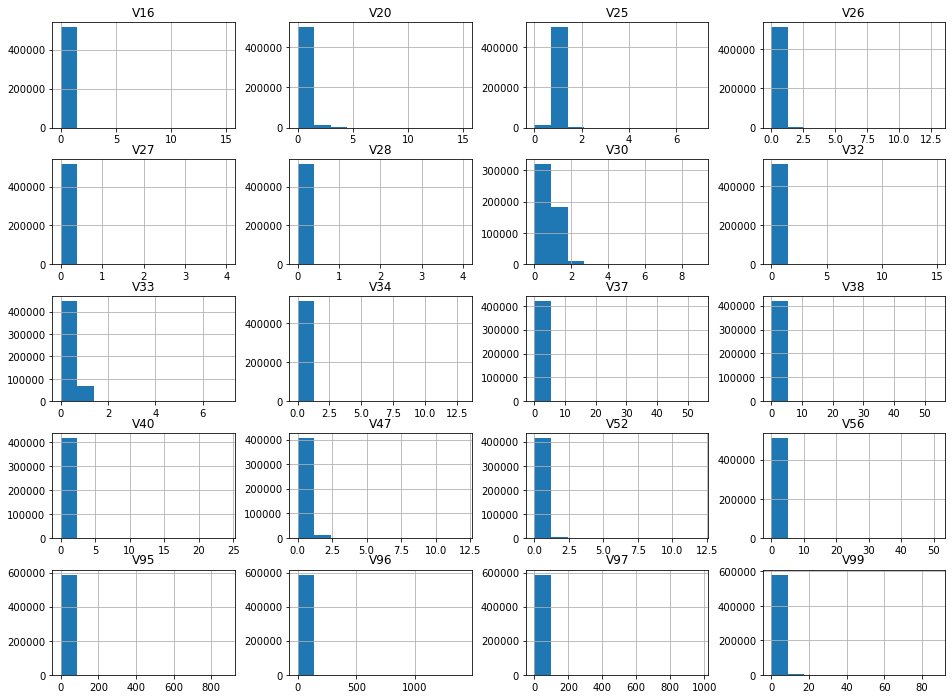

In [335]:
v_cols.loc[:, [x for x in v_cols if x not in true_list]].iloc[:,:20].hist(figsize=(16,12))
plt.show()

[[['V1',
   'V2',
   'V3',
   'V4',
   'V5',
   'V6',
   'V7',
   'V8',
   'V9',
   'V10',
   'V11',
   'V12',
   'V13',
   'V14',
   'V15',
   'V17',
   'V18',
   'V19',
   'V21',
   'V22',
   'V23',
   'V24',
   'V29',
   'V31',
   'V35',
   'V36',
   'V39',
   'V41',
   'V42',
   'V43',
   'V44',
   'V45',
   'V46',
   'V48',
   'V49',
   'V50',
   'V51',
   'V53',
   'V54',
   'V55',
   'V57',
   'V58',
   'V59',
   'V60',
   'V61',
   'V62',
   'V63',
   'V64',
   'V65',
   'V66',
   'V67',
   'V68',
   'V69',
   'V70',
   'V71',
   'V72',
   'V73',
   'V74',
   'V75',
   'V76',
   'V77',
   'V78',
   'V79',
   'V80',
   'V81',
   'V82',
   'V83',
   'V84',
   'V85',
   'V86',
   'V87',
   'V88',
   'V89',
   'V90',
   'V91',
   'V92',
   'V93',
   'V94',
   'V98',
   'V100',
   'V104',
   'V107',
   'V108',
   'V109',
   'V110',
   'V111',
   'V112',
   'V113',
   'V114',
   'V115',
   'V116',
   'V117',
   'V118',
   'V119',
   'V120',
   'V121',
   'V122',
   'V123',
   'V124',

In [342]:
foo = pd.Series()
for c in dummies.columns:
    foo[c] = c
    
foo = foo.str.slice(0,5)

<ipython-input-342-d9e56d8d0f35>:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  foo = pd.Series()


In [343]:
foo

PrdCD_C        PrdCD
PrdCD_H        PrdCD
PrdCD_R        PrdCD
PrdCD_S        PrdCD
PrdCD_W        PrdCD
               ...  
adr1__531.0    adr1_
adr1__535.0    adr1_
adr1__536.0    adr1_
adr1__540.0    adr1_
adr1__nan      adr1_
Length: 471, dtype: object

In [344]:
foo.unique()

array(['PrdCD', 'crd4_', 'credi', 'debit', 'other', nan, 'P_eml', 'R_eml',
       'M1_T', 'M1_na', 'M2_T', 'M2_na', 'M3_T', 'M3_na', 'M4_M1',
       'M4_M2', 'M4_na', 'M5_T', 'M5_na', 'M6_T', 'M6_na', 'M7_T',
       'M7_na', 'M8_T', 'M8_na', 'M9_T', 'M9_na', 'adr2_', 'adr1_'],
      dtype=object)